# Cart Pole

In [3]:
import torch
from torch import nn, optim, tensor
# from torchsummary import summary

import gym

from collections import deque, namedtuple

import matplotlib
import matplotlib.pyplot as plt

import random

from math import exp

import numpy as np
from itertools import compress
import time
import json
from src.Runner2048 import Game

## Setup

In [4]:
# So we can run off of the GPU for our tensors
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

# Live plots
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

plt.rcParams['figure.figsize'] = [10, 8]

print(device)

cuda


## Environment

In [94]:
# env = Game(seed=1, board_size=4, reward_type='duration_and_largest')
env = Game(seed=1, board_size=4, reward_type='duration_and_whitespace')
action_dict = {0:'U', 1:'R', 2:'D', 3:'L'}

# env = gym.make("LunarLander-v2")

## Parameters

In [116]:
# Parameters
nS = 16
nA = 4

# Hyperparameters
BATCH_SIZE = 128
# BATCH_SIZE = 2**5

LAYER1_SIZE = 1024
LAYER2_SIZE = 1024

EPISODES_TRAINING = 1000
# EPISODES_TRAINING = 2000
# EPISODES_TRAINING = 50000

ALPHA = 0.1
GAMMA = 0.7
# TAU = 0.005
TAU = 0.1
EPSILON_MAX = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 250
# EPSILON_DATA = [EPSILON_MAX, EPSILON_MIN, EPSILON_DECAY]

# BUFFER_SIZE = 10000
BUFFER_SIZE = 10000

## Replay Buffer

In [117]:
SARST = namedtuple("SARST", ["S", "A", "R", "S_prime", "T"])

class ReplayBuffer(object):
    def __init__(self, size):
        self.buffer = deque([], size)

    def push(self, *args):
        self.buffer.append(SARST(*args))
        # Rotate the board and add it to the buffer
        if (True):
            # 90 degrees CCW
            S_new = tensor([np.rot90(args[0].cpu().view(4,4)).flatten()]).to(device)
            A_new = (args[1]-1)%4
            if (args[3] == [0]):
                S_prime_new = args[3]
            else:
                S_prime_new = tensor([np.rot90(args[3].cpu().view(4,4)).flatten()]).to(device)
            self.buffer.append(SARST(S_new, A_new, args[2], S_prime_new, args[4]))

            # 180 degrees CCW
            S_new = tensor([np.rot90(S_new.cpu().view(4,4)).flatten()]).to(device)
            A_new = (A_new-1)%4
            if (args[3] == [0]):
                S_prime_new = args[3]
            else:
                S_prime_new = tensor([np.rot90(S_prime_new.cpu().view(4,4)).flatten()]).to(device)
            self.buffer.append(SARST(S_new, A_new, args[2], S_prime_new, args[4]))

            # 270 degrees CCW
            S_new = tensor([np.rot90(S_new.cpu().view(4,4)).flatten()]).to(device)
            A_new = (A_new-1)%4
            if (args[3] == [0]):
                S_prime_new = args[3]
            else:
                S_prime_new = tensor([np.rot90(S_prime_new.cpu().view(4,4)).flatten()]).to(device)
            self.buffer.append(SARST(S_new, A_new, args[2], S_prime_new, args[4]))

            # Flip Virt
            S_new = tensor([np.flip(args[0].cpu().view(4,4).numpy(), axis=0).flatten()]).to(device)
            if (args[1]%2 == 0):
                A_new = (args[1]-2)%4
            else:
                A_new = args[1]
            
            if (args[3] == [0]):
                S_prime_new = args[3]
            else:
                S_prime_new = tensor([np.flip(args[3].cpu().view(4,4).numpy(), axis=0).flatten()]).to(device)
            self.buffer.append(SARST(S_new, A_new, args[2], S_prime_new, args[4]))
            
            # Flip Horz
            S_new = tensor([np.flip(args[0].cpu().view(4,4).numpy(), axis=1).flatten()]).to(device)
            if (args[1]%2 == 1):
                A_new = (args[1]-2)%4
            else:
                A_new = args[1]
            
            if (args[3] == [0]):
                S_prime_new = args[3]
            else:
                S_prime_new = tensor([np.flip(args[3].cpu().view(4,4).numpy(), axis=1).flatten()]).to(device)
            self.buffer.append(SARST(S_new, A_new, args[2], S_prime_new, args[4]))


    def sample(self, sample_size):
        return random.sample(self.buffer, sample_size)
    
    def __len__(self):
        return len(self.buffer)

In [118]:
BOARDBUFF = namedtuple("BOARDBUFF", ["S", "D"]) # Board state, Game duration

class BoardBuffer(object):
    def __init__(self, size):
        self.buffer = deque([], size)

    def push(self, *args):
        self.buffer.append(BOARDBUFF(*args))

    # def sample(self, sample_size):
    #     return random.sample(self.buffer, sample_size)

    def pop_sample(self):
        pop_index = random.randint(0, len(self.buffer)-1)
        return_board = self.buffer[pop_index]
        del self.buffer[pop_index]
        return return_board
    
    # def remove(self, occurence):
    #     self.buffer.remove(occurence)
    
    def __len__(self):
        return len(self.buffer)
    
BOARDCACHE = namedtuple("BOARDCACHE", ["S", "D"]) # Board state, Game duration

class BoardCache(object):
    def __init__(self, size):
        self.buffer = deque([], size)

    def clear(self):
        self.buffer.clear()

    def push(self, *args):
        self.buffer.append(BOARDCACHE(*args))

    def get_first(self):
        return self.buffer.popleft()
    
    def __len__(self):
        return len(self.buffer)

## DQN

In [119]:
class DQN(nn.Module):
    def __init__(self, INPUT_LAYER, LAYER1_SIZE, LAYER2_SIZE, OUTPUT_LAYER):
        super(DQN, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(INPUT_LAYER, LAYER1_SIZE),
            nn.ReLU(),
            nn.Linear(LAYER1_SIZE, LAYER2_SIZE),
            nn.ReLU(),
            nn.Linear(LAYER2_SIZE, OUTPUT_LAYER),
        ).to(device)

    def forward(self, x):
        return self.linear_relu_stack(x)
    
    
class DQNM(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQNM, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        # self.fc4 = nn.Linear(2048, 512)
        # self.fc4b = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(1024, output_size)
        self.leaky_relu = nn.LeakyReLU(0.01)
        self.sm = nn.Softmax(dim=0)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        # x = self.fc4(x)
        # x = torch.relu(self.fc4b(x))
        # x = torch.relu(self.fc5(x))
        # return self.sm(self.fc3(x))
        return self.fc5(x)
    
class DQCNN(nn.Module):
    def __init__(self, KERNEL_SIZE, LAYER1_SIZE, LAYER2_SIZE, OUTPUT_LAYER):
        super(DQCNN, self).__init__()
        self.cnn = nn.Sequential(   #(H + self.padding*2 - self.kernel_size) // self.stride + 1 -> 4 + 2 - 3 // 1 + 1 = 4
            nn.Conv2d(in_channels=1,  out_channels=16, kernel_size=KERNEL_SIZE, stride=1, padding=1),  # 1x4x4  -> 16x4x4
            nn.ReLU(),  # 16x4x4
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=KERNEL_SIZE, stride=1, padding=1),  # 16x4x4 -> 32x4x4
            nn.ReLU(),  # 32x4x4
            nn.Flatten(),   # 32*4*4 = 512
            nn.Linear(512, LAYER1_SIZE),
            nn.ReLU(),
            nn.Linear(LAYER1_SIZE, LAYER2_SIZE),
            nn.ReLU(),
            nn.Linear(LAYER2_SIZE, LAYER2_SIZE),
            nn.ReLU(),
            nn.Linear(LAYER2_SIZE, OUTPUT_LAYER),
            )
        
    def forward(self, x):
        return self.cnn(x)

class DQCNNS(nn.Module):
    def __init__(self, KERNEL_SIZE, LAYER1_SIZE, LAYER2_SIZE, OUTPUT_LAYER):
        super(DQCNNS, self).__init__()
        self.cnn = nn.Sequential(   #(H + self.padding*2 - self.kernel_size) // self.stride + 1 -> 4 + 2 - 3 // 1 + 1 = 4
            nn.Conv2d(in_channels=1,  out_channels=64, kernel_size=KERNEL_SIZE, stride=1, padding=1),  # 1x4x4  -> 16x4x4
            nn.ReLU(),  # 16x4x4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=KERNEL_SIZE, stride=1, padding=1),  # 16x4x4 -> 32x4x4
            nn.ReLU(),  # 32x4x4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2, stride=1, padding=0),  # 32x4x4 -> 64x3x3
            nn.Flatten(),   # 32*4*4 = 512
            nn.Linear(2304, LAYER1_SIZE),
            nn.ReLU(),
            nn.Linear(LAYER1_SIZE, LAYER2_SIZE),
            nn.ReLU(),
            nn.Linear(LAYER2_SIZE, LAYER2_SIZE),
            nn.ReLU(),
            nn.Linear(LAYER2_SIZE, OUTPUT_LAYER),
            )
        
    def forward(self, x):
        return self.cnn(x)
    
class HLCNN(nn.Module): # Human Level Control NN (Paper)
    def __init__(self, OUTPUT_LAYER):
        super(HLCNN, self).__init__()
        self.cnn = nn.Sequential(   #(H + self.padding*2 - self.kernel_size) // self.stride + 1 -> 4 + 4 - 4 // 1 + 1 = 4
            # nn.Conv2d(in_channels=1,  out_channels=32, kernel_size=4, stride=1, padding='same'),  # 1x4x4  -> 32x4x4
            # nn.ReLU(),  # 32x4x4
            # nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),  # 32x4x4 -> 64x4x4
            # nn.ReLU(),  # 64x4x4
            nn.Conv2d(in_channels=1,  out_channels=32, kernel_size=4, stride=1, padding='same'),  # 1x4x4  -> 32x4x4
            nn.ReLU(),  # 32x4x4
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),  # 32x4x4 -> 64x4x4
            nn.ReLU(),  # 64x4x4
            nn.Flatten(),   # 64*4*4 = 1024
            nn.Linear(1024, 2**9),  # 2^9 = 512
            nn.ReLU(),
            nn.Linear(2**9, 2**9),  # 2^9 = 512
            nn.ReLU(),
            nn.Linear(2**9, OUTPUT_LAYER),  # 512
            )
        
    def forward(self, x):
        return self.cnn(x)

## Epsilon Greedy

In [120]:
def epsilonGreedy(state, network, nA, epsilon):
    # Decide if we are going to be greedy or not
    greedy = (random.random() > epsilon)

    if greedy:
        # Pick best action, if tie, use lowest index
        with torch.no_grad():   # Speeds up computation
            return network(state).argmax().item()
            # return network(state.view(1,1,4,4)).argmax().item()

    else:
        # Explore
        return tensor(random.randint(0, nA-1), device=device, dtype=torch.long).item()


## Setup

In [121]:
# policy_net = DQN(nS, LAYER1_SIZE, LAYER2_SIZE, nA).to(device)
# target_net = DQN(nS, LAYER1_SIZE, LAYER2_SIZE, nA).to(device)
# policy_net = DQCNN(3, LAYER1_SIZE, LAYER2_SIZE, nA).to(device)
# target_net = DQCNN(3, LAYER1_SIZE, LAYER2_SIZE, nA).to(device)
# policy_net = HLCNN(nA).to(device)
# target_net = HLCNN(nA).to(device)
# policy_net = DQCNNS(3, LAYER1_SIZE, LAYER2_SIZE, nA).to(device)
# target_net = DQCNNS(3, LAYER1_SIZE, LAYER2_SIZE, nA).to(device)
policy_net = DQNM(nS, nA).to(device)
target_net = DQNM(nS, nA).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=ALPHA, amsgrad=True)
RB = ReplayBuffer(BUFFER_SIZE)


In [122]:
steps = 0
def getEpsilon():
    global steps
    epsilon = EPSILON_MIN + (EPSILON_MAX - EPSILON_MIN)*exp(-steps/EPSILON_DECAY)
    steps += 1
    return epsilon

## Stolen Plot Function

In [123]:
def plot_multi(title, axis, args, save_string=""):
    n_plots = len(args)
    plt.clf()
    fig, ax = plt.subplots(n_plots, 1, sharex=True)
    for argi, arg in enumerate(args):
        data = torch.tensor(arg, dtype=torch.float)
        # ax[argi].clf()
        # ax[argi].clear()
        ax[argi].set_title(title[argi])
        ax[argi].set_ylabel(axis[argi])
        # ax[argi].set_xlabel('Episode')
        ax[argi].plot(data)

        # Take 50 episode averages and plot them too
        if len(arg) >= 50:
            means = data.unfold(0, 50, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(49), means))
            ax[argi].plot(means.numpy())
            
    plt.xlabel('Episode')
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)
    if save_string != "":
        fig.savefig("./figures/"+save_string+".png")

        # if is_ipython:
        #     display.display(plt.gcf())
        


##

In [124]:
def train():
    minibatch_awk = RB.sample(BATCH_SIZE)
    minibatch = SARST(*zip(*minibatch_awk))
    
    N = len(minibatch.S)

    S = torch.cat(minibatch.S).to(device)
    # S = S.view(N, 1, 4, 4)
    A = minibatch.A
    torch_R = torch.cat(minibatch.R).to(device)
    torch_maxQ = torch.zeros(N, 1).to(device)
    nonterm_mask = tensor(minibatch.T).to(device)
    # term_mask = tensor(list(np.array(minibatch.T)==False))
        
    Q_SA = policy_net(S).gather(1, torch.reshape(tensor(A).to(device), [N, 1]))
    
    with torch.no_grad():
        S_prime_masked =  list(compress(minibatch.S_prime, minibatch.T))
        torch_maxQ[nonterm_mask] = torch.reshape(target_net(torch.cat(S_prime_masked)).max(1)[0], [sum(nonterm_mask).item(), 1])
        # S_prime_masked =  list(compress(minibatch.S_prime, minibatch.T))
        # torch_maxQ[nonterm_mask] = torch.reshape(target_net(torch.cat(S_prime_masked).to(device).view(sum(nonterm_mask), 1, 4, 4)).max(1)[0], [sum(nonterm_mask).item(), 1])

    y = (torch_maxQ * GAMMA) + torch_R

    # Compute Huber loss
    criterion = nn.MSELoss()
    loss = criterion(Q_SA, y)

    # Clipping the loss between -1 and 1
    # loss = torch.mean(torch.maximum(torch.minimum((Q_SA-y)**2, tensor(1)), tensor(-1)))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    return loss.item()
    

In [127]:
episodic_rewards = []
episodic_loss = []
episodic_epsilon = []
episdoic_duration = []
episdoic_max_tile = []
episodic_revision_count = []

# use_midgame_board = False
# BB = BoardBuffer(100)
# BC = BoardCache(50)

def DQN_network(episodes):
    save_tag = "duration_and_whitespace"
    start_time = time.time()
    T = 0
    for epi in range(episodes):
        
        # BC.clear()
        # if (use_midgame_board and (len(BB) > 100) and (0.1 > random.random())): # Randomly select from the board buffer
        #     loadBB = BB.pop_sample()
        #     S = env.load_board(loadBB.S, loadBB.D)
        #     S = torch.tensor([S], dtype=torch.float32, device=device)


        # else:
        S = env.reset()
        S = torch.tensor([S], dtype=torch.float32, device=device)

            # BC.push(S, 0)

        episodic_reward = 0
        episodic_mean_loss = 0
        terminated = False
        episodic_revision = 0
        
        epsilon = getEpsilon()
        
        mini_duration = 0
        while not terminated:
            T += 1
            mini_duration += 1
            # if True and epi%10==0:
            #     env.render()

            # Choose action
            A = epsilonGreedy(S, policy_net, nA, epsilon)
            # Take step
            reward, terminated, updated, A, revision_count = env.swipe(action_dict[A])
            S_prime = env.get_flat_board()
            episodic_revision += revision_count
            
            # S_prime = None if terminated else tensor(torch.FloatTensor(S_prime).to(device), requires_grad=True)
            S_prime = [0] if terminated else tensor([S_prime], dtype=torch.float32, device=device)

            # Store the transition
            # RB.push(S, A, tensor([[reward]], dtype=torch.float32, device=device), 
            #         S_prime, tensor(not terminated, device=device, dtype=torch.bool))
            RB.push(S, A, tensor([[reward]], dtype=torch.float32, device=device), 
                    S_prime, not terminated)

            S = S_prime
            # if (terminated):
            #     BC.push(S, env.game_duration) # Just filler really 
            # else:
            #     BC.push(S.view(4,4).cpu().numpy(), env.game_duration)
            
            # Update the networks networks
            if len(RB) > BATCH_SIZE:
                episodic_mean_loss += train()
                
            episodic_reward += reward

            if T%10==0:
                # Soft update of the target network's weights
                target_net_state_dict = target_net.state_dict()
                policy_net_state_dict = policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                target_net.load_state_dict(target_net_state_dict)
            
        # if (mini_duration > 50):
        #     tempBC = BC.get_first()
        #     BB.push(tempBC[0], tempBC[1])

        episodic_epsilon.append(epsilon)
        episodic_loss.append(episodic_mean_loss/T)
        episodic_rewards.append(episodic_reward)
        episdoic_duration.append(env.game_duration)
        episdoic_max_tile.append(max(env.get_flat_board()))
        episodic_revision_count.append(episodic_revision)

        if epi % 100 == 0:
            save_string = "_policy_weights_episode_"+str(epi).zfill(4)
            torch.save(target_net.state_dict(), "./trained_models/"+save_tag+"_"+"target"+save_string+".pth")
            torch.save(policy_net.state_dict(), "./trained_models/"+save_tag+"_"+"policy"+save_string+".pth")
                
            # # Soft update of the target network's weights (do at end of episode)
            # target_net_state_dict = target_net.state_dict()
            # policy_net_state_dict = policy_net.state_dict()
            # for key in policy_net_state_dict:
            #     target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            # target_net.load_state_dict(target_net_state_dict)

            # print()
            # print()
            # print()
            # print()
            # print()
            
        if epi % 50 == 0:
            print(epsilon)
            env.display()
            plot_multi(["Training Rewards...", "Training Loss...", "Duration...", "Max Episodic Value...", "Invalid Moves...", "Epsilon Value..."], 
                       ["Reward", "Mean Episode Loss", "Duration", "Max Tile Value", "Invalid Moves", "Epsilon"], 
                       [episodic_rewards, episodic_loss, episdoic_duration, episdoic_max_tile, episodic_revision_count, episodic_epsilon])
        
                
    
    delta_time = time.time()-start_time
    plot_multi(["Reward History", "Loss History", "Duration", "Max Episodic Value", "Invalid Moves", "Epsilon History"], 
               ["Reward", "Loss", "Duration", "Max Tile Value", "Invalid Moves", "Epsilon"], 
               [episodic_rewards, episodic_loss, episdoic_duration, episdoic_max_tile, episodic_revision_count, episodic_epsilon], save_string="model_"+save_tag+"")
    
    plt.ioff()
    plt.show()
    
    # Save data
    # data_file = open("./trainged_models/data.json", 'w+')
    # json_data = {"episodic_rewards": episodic_rewards, 
    #                 "episodic_loss": episodic_loss, 
    #                 "episodic_epsilon": episodic_epsilon,
    #                 "training_time": delta_time
    #                 }
    # json.dump(json_data, data_file)

<Figure size 1000x800 with 0 Axes>

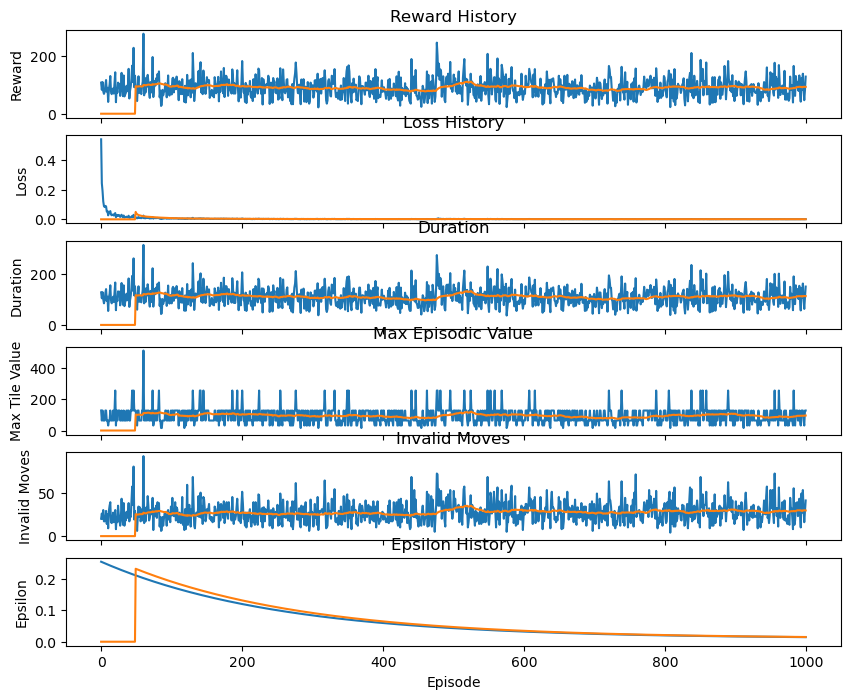

In [128]:
DQN_network(EPISODES_TRAINING)
# env.close()

In [ ]:
# data_file = open("./trainged_models/data_CNN.json", 'w+')
# json_data = {"episodic_rewards": episodic_rewards, 
#                 "episodic_loss": episodic_loss, 
#                 "episodic_epsilon": episodic_epsilon,
#                 "training_time": delta_time
#                 }
# json.dump(json_data, data_file)

In [129]:
env.close()

AttributeError: 'Game' object has no attribute 'close'

In [131]:
# from tqdm import tqdm
def test(episodes):
    episodic_rewards = []
    episodic_durations = []

    for epi in range(episodes):

        
        S = env.reset()
        S = torch.tensor([S], dtype=torch.float32, device=device)

        episodic_reward = 0
        episodic_duration = 0
        T = 0
        terminated = False
        while not terminated:
            episodic_duration += 1
            env.render()

            # Choose action
            A = epsilonGreedy(S, policy_net, nA, -1)
            # Take step
            S_prime, reward, terminated, _ = env.step(A)
            S = S_prime

            episodic_reward += reward

        episodic_rewards.append(episodic_reward)
        episodic_durations.append(episodic_duration)
        # if epi % 10 == 0:
        print(epi, "of", episodes)
        plot_multi(["Training Rewards...", "Training Durations..."], 
                    ["Reward", "Episode Duration"], 
                    [episodic_rewards, episodic_durations])
            
        